<a href="https://colab.research.google.com/github/HannaKi/kandi/blob/master/sentiment_analysis_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction/Johdanto

Hi/Hei!

The primary purpose of this notebook is to demonstrate how to use SHAP (SHapley Additive exPlanations) library to explain predictions of a Transformers model, namely BERT. Please observe that many crucial details (e.g. optimal batch size, naive baseline, choice of metrics, error analysis) to properly train a NLP model are omitted to pursue the goal with as brief notebook as possible. 

You can train a model with this notebook if you wish. I have opted to download model weights from my Drive after compiling the model.

Tämän tiedoston pääasiallinen tarkoitus on demonstroida SHAP-kirjaston (SHapley Additive exPlanations) käyttöä Transformers-mallin ennusteiden tulkintaan. Huomaathan, että monia mallin kunnollisen opettamisen ja suoriutumisen kannalta olennaisia vaiheita on ohitettu (mm. treenaamisen syötteen koko, engl. batch, vertailualgoritmin tutkiminen, metriikan valikointi, virheanalyysi), jotta tiedosto pysyy kompaktina.

Voit halutessasi treenata mallin tällä työkirjalla. olen oletusarvoisesti ohittanut treenaamisen ja hyödyntänyt tallentamiani painoarvoja mallin konstruoimisen jälkeen.

Sources/lähteet:

- [TensorFlow way to train model](https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/text_classification.ipynb)
- [SHAP GitHub](https://github.com/slundberg/shap), [SHAP documentation](https://shap.readthedocs.io/en/latest/index.html), [SHAP NLP example](https://github.com/slundberg/shap#natural-language-example-transformers), [SHAP sentiment example](https://github.com/slundberg/shap/blob/master/notebooks/text_examples/sentiment_analysis/Positive%20vs.%20Negative%20Sentiment%20Classification.ipynb)
- [HuggingFace pipelines](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#)


In [1]:
! pip --quiet install git+https://github.com/huggingface/transformers.git
! pip --quiet install git+https://github.com/huggingface/datasets.git
# ! pip --quiet install scipy sklearn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 5.0 MB/s 
     |████████████████████████████████| 101 kB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 61.4 MB/s 
     |████████████████████████████████| 212 kB 5.0 MB/s 
     |████████████████████████████████| 140 kB 66.8 MB/s 
     |████████████████████████████████| 1.1 MB 59.9 MB/s 
     |████████████████████████████████| 127 kB 73.2 MB/s 
     |████████████████████████████████| 271 kB 72.3 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 144 kB 79.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import transformers

print(transformers.__version__)

4.21.0.dev0


# Fine-tuning a model / Mallin opettaminen 

In [3]:
model_checkpoint ="bert-base-cased" # name from Hugging Face repository
batch_size = 6 # to not to OOM
TRAIN = False # by assumption use the model finetuned with IMDB data and saved to personal Google Drive. 

## Loading the dataset / Datan lataus

https://github.com/huggingface/datasets/tree/master/datasets/imdb: 

label: a classification label, with possible values including neg (0), pos (1).

In [4]:
import datasets

In [5]:
train, test = datasets.load_dataset("imdb", split=["train", "test"], download_mode='force_redownload')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
dataset = datasets.DatasetDict({'train': train, 'test': test})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
## To access an actual element, you need to select a split first, then give an index:
# for i in range(0,200,40):
#   print(dataset["train"]["label"][i], "\t", dataset["train"]["text"][i])

In [8]:
import numpy as np

num_labels=len(np.unique(dataset["train"]["label"])) # luokkien lukumäärä
# print(np.unique(dataset["train"]["label"]))
# num_labels

In [9]:
# Downsize the data set splits

dataset["train"] = dataset["train"].filter(lambda example, idx: idx % 20 == 0, with_indices=True)
# split test data to validation and test and downsample both
dataset["validation"] = dataset["test"].filter(lambda example, idx: idx % 2 == 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)
dataset["test"] = dataset["test"].filter(lambda example, idx: idx % 2 != 0, with_indices=True).filter(lambda example, idx: idx % 30 == 0, with_indices=True)
# if index is divisible with 10, select the instance

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1250
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
})

## Preprocess the data

Preprocess with a tokenizer. 
- get a tokenizer that corresponds to the model architecture
- download the vocabulary used when pretraining this specific checkpoint.

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Write the function that will preprocess our samples.
- feed them to the `tokenizer` with the arguments `truncation=True` and `padding='longest`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model, and all inputs will be padded to the maximum input length to give us a single input array. 

- A more performant method that reduces the number of padding tokens is to write a generator or `tf.data.Dataset` to only pad each *batch* to the maximum length in that batch

In [12]:
# preprocess_function(dataset["train"][:5])

In [13]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

#preprocess_function(dataset["train"][:5])

apply this function on all the sentences.

In [14]:
pre_tokenizer_columns = set(dataset["train"].features)
encoded_dataset = dataset.map(preprocess_function, batched=True) # atched=True to encode the texts by batches together. 
# This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['token_type_ids', 'input_ids', 'attention_mask']


In [15]:
encoded_dataset["train"].features["label"]

ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)

you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Finally, we convert our datasets to `tf.data.Dataset`. There's a built-in method for this, so all you need to do is specify the columns you want (both for the inputs and the labels), whether the data should be shuffled, the batch size, and an optional collation function, that controls how a batch of samples is combined.

We'll need to supply a `DataCollator` for this. The `DataCollator` handles grouping each batch of samples together, and different tasks will require different data collators. In this case, we will use the `DataCollatorWithPadding`, because our samples need to be padded to the same length to form a batch. Remember to supply the `return_tensors` argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.

In [16]:
from transformers import DataCollatorWithPadding

# Data_collator controls how a batch of samples is combined.
# Use DataCollatorWithPadding, because our samples need to be padded to the same length to form a batch. 
# Remember to supply the return_tensors argument too - our data collators can handle multiple frameworks, so you need to be clear that you want TensorFlow tensors back.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf") 

tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["validation"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_test_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["labels"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [17]:
#encoded_dataset["test"]

In [18]:
#tf_test_dataset

In [22]:
# See availabe metrics: https://huggingface.co/metrics
metric = datasets.load_metric('accuracy')

## Fine-tuning the model

In [23]:
# To connect Google account to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# %%bash
# cd gdrive/MyDrive/bachelor_thesis
# mkdir model_checkpoints
# ls

In [25]:
file_path="/content/drive/MyDrive/bachelor_thesis/model_checkpoints/model.hdf5"

- download the pretrained model and fine-tune it (`TFAutoModelForSequenceClassification` class). 
  - specify the number of labels for our problem 
- get the appropriate loss function (SparseCategoricalCrossentropy)


In [26]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels = dataset["train"].features["label"].num_classes
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
# from_logits=True: Whether y_pred is expected to be a logits tensor. 
# from_logits=False: We assume that y_pred encodes a probability distribution. 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). **This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights**, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

- create a `AdamW` optimizer with weight and learning rate decay. Note that because it decays the learning rate over the course of training, it needs to know how many batches it will see during training.
- L2 regularization (a.k.a. weight decay, ridge regression) penalizes model for being too complex. The regularization penalty multiplied by weight is added to the total loss of the network. Hence we are punishing for higher weights and expect that none of the model parameters is drastically more important than the other ones.

In [27]:
from transformers import create_optimizer

num_epochs = 2 #5 
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, loss=loss)

The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits.

let's wrap this metric computation function in a KerasMetricCallback. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

In [28]:
from transformers.keras_callbacks import KerasMetricCallback
import numpy as np

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    predictions = np.argmax(predictions, axis=1) # argmax of our predicted logits (indeksi, jossa on ennusteen suuri arvo. Indeksi = luokka)
    return metric.compute(predictions=predictions, references=labels) # call for the metrics instantiated in chapter "Metrics"

# add Keras metrics to get live readouts during training 
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_dataset
)

We can now finetune our model by just calling the `fit` method. Be sure to pass the TF datasets, and not the original datasets! We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if TRAIN:
  model_checkpoint_callback = ModelCheckpoint(filepath=file_path, 
                          monitor='val_loss', 
                          verbose=1, 
                          save_best_only=True, 
                          save_weights_only=True, # only the weights are saved. To use them a model is needed but it can be saved elsewhere or restored from this notebook
                          save_freq='epoch', # save after every epoch
                          mode='auto')

  callbacks = [metric_callback, model_checkpoint_callback]

  model.fit(
      tf_train_dataset,
      validation_data=tf_validation_dataset,
      verbose=1,
      epochs=1, #3,
      callbacks=[callbacks],
  )

else: 
  model.load_weights(file_path)

Predict with test data and calculate test accuracy


In [30]:
predictions = model.predict(tf_test_dataset)["logits"]
predictions[:5]

array([[ 0.3507655, -1.0008607],
       [-1.9121766,  1.7757229],
       [ 0.30786  , -1.1297804],
       [ 1.5143837, -1.7531375],
       [ 1.7868872, -1.8565449]], dtype=float32)

In [31]:
import numpy as np

preds=np.argmax(predictions, axis=1)
true=np.array(encoded_dataset["test"]['label'])
metric.compute(predictions=preds, references=true)

{'accuracy': 0.894484412470024}

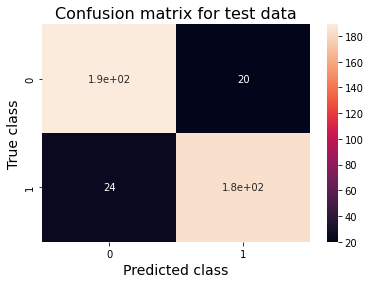

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Columns represent the predicted labels and the rows represent the real labels

cf_mat = tf.math.confusion_matrix(
    true, preds, num_classes=None, weights=None, dtype=tf.dtypes.int64,
    name=None
)
def plot_cf_matrix(mat):
  sns.heatmap(mat, annot=True)
  plt.title("Confusion matrix for test data", fontsize = 16)
  plt.ylabel("True class", fontsize = 14)
  plt.xlabel("Predicted class", fontsize = 14)


plot_cf_matrix(cf_mat)

# SHAP explanations

API: https://github.com/slundberg/shap/blob/master/docs/api.rst#id1
text_examples/sentiment_analysis


In [33]:
!pip --quiet install shap

     |████████████████████████████████| 569 kB 4.9 MB/s 


Now that the model has been defined we can use [a transformer pipeline](https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores#). 

A transformers pipeline object can be passed directly to shap.Explainer, which will then wrap the pipeline model as a shap.models.TransformersPipeline model and the pipeline tokenizer as a shap.maskers.Text masker. [source](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)

In [34]:
import shap
# https://huggingface.co/transformers/v3.0.2/main_classes/pipelines.html?highlight=return_all_scores

# classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True)
# classifier(short_data[:2])

# Now that the model has been defined we can use transformer pipeline 
# Pass the tokenizer as the masker object
classifier = transformers.pipeline(task='sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)
short_data = [v[:300] for v in dataset["test"]["text"][:20]] # first 300 letters from the first 20 test split texts
classifier(short_data[:2]) # pipeline predictions for the 2 first samples in the "short_data"
#  In this data set LABEL_0=negative, LABEL_1=positive

`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality


[[{'label': 'LABEL_0', 'score': 0.0159439779818058},
  {'label': 'LABEL_1', 'score': 0.9840559959411621}],
 [{'label': 'LABEL_0', 'score': 0.024413608014583588},
  {'label': 'LABEL_1', 'score': 0.9755864143371582}]]

In [35]:
# define the explainer

explainer = shap.Explainer(classifier)
#explainer = shap.Explainer(model, masker=tokenizer, algorithm='partition')

In [37]:
explainer

In [39]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:2])

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 3it [10:25, 312.92s/it]


In [40]:
short_data[:2]

['Worth the entertainment value of a rental, especially if you like action movies. This one features the usual car chases, fights with the great Van Damme kick style, shooting battles with the 40 shell load shotgun, and even terrorist style bombs. All of this is entertaining and competently handled bu',
 'This film features two of my favorite guilty pleasures. Sure, the effects are laughable, the story confused, but just watching Hasselhoff in his Knight Rider days is always fun. I especially like the old hotel they used to shoot this in, it added to what little suspense was mustered. Give it a 3.']

In [41]:
type(shap_values)

shap._explanation.Explanation

In [42]:
shap_values[0]

.values =
array([[-0.00369922,  0.00369922],
       [-0.00369922,  0.00369922],
       [-0.00995931,  0.00995932],
       [-0.00593217,  0.00593218],
       [-0.00734276,  0.00734276],
       [-0.00311292,  0.00311292],
       [-0.00719583,  0.00719582],
       [ 0.00342219, -0.0034222 ],
       [ 0.00618109, -0.00618109],
       [ 0.00368358, -0.00368358],
       [ 0.00432499, -0.00432499],
       [-0.00852342,  0.00852342],
       [-0.00695944,  0.00695945],
       [ 0.00326479, -0.00326479],
       [ 0.01493314, -0.01493314],
       [-0.01548971,  0.0154897 ],
       [-0.0076778 ,  0.00767779],
       [-0.0076778 ,  0.00767779],
       [-0.0146814 ,  0.0146814 ],
       [-0.01010969,  0.01010969],
       [ 0.00145324, -0.00145324],
       [ 0.00145324, -0.00145324],
       [ 0.00087173, -0.00087173],
       [ 0.00087173, -0.00087173],
       [-0.00169606,  0.00169606],
       [-0.00842965,  0.00842965],
       [-0.00743873,  0.00743873],
       [-0.00525138,  0.00525138],
       [-0

In [43]:
len(shap_values[0].values)

62

In [44]:
len(shap_values[0].data)

62

In [ ]:
shap_values[0].values.shape

In [45]:
sum(shap_values[0].base_values)

1.0000000596046448

In [52]:
np.sum(shap_values[0].values, axis=0)

array([-0.3117257 ,  0.31172562])

In [46]:
#  Base value is the average model output (based on provided training data)
shap.plots.text(shap_values[:,:,"LABEL_1"]) # label value 1 is positive for the IMDB data

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
shap.plots.text(shap_values[:,:,"LABEL_0"]) 

In [ ]:
shap.plots.bar(shap_values[0,:,"LABEL_1"])

In [ ]:
sentences = ["What a great movie! Loved it from the very start till the end.", "Terrible crap, hated it", "Lovely story, love love love"]
for s in sentences:
  print(s)
  print(classifier(s)) 
  shap_vals = explainer(s)
  shap.plots.text(shap_vals[:,:,"LABEL_1"])
  shap_vals
  break

In [ ]:
sentence = ["What a great movie! Loved it from the very start till the end."]
shap_vals = explainer(sentence)
shap.plots.text(shap_vals[:,:,"LABEL_1"])

In [ ]:
shap_vals

In [ ]:
shap_vals.values

In [ ]:
sum(sum(shap_vals.values))

In [ ]:
# explainer_2 = shap.Explainer(model=model, masker=shap.maskers.Text, algorithm='partition')
# shap_values_2 = explainer_2(short_data[:2])

In [38]:
masker = shap.maskers.Text(classifier.tokenizer)